In [37]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

gpus = tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True)    # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V2 import *
import aux_func_numpy as debug

In [38]:
# Função que define a taxa de aprendizagem para diferentes
# iterações de treino, a ideia é começar com uma taxa grande e 
# diminuir ao longo do treino para "refinar" a aprendizagem da rede

def scheduler(epoch, lr):
    if epoch < 1:
        return 10**-2
    elif epoch<2:
        return 10**-3
    else:
        return 10**-4
    
# Passando para o keras a função scheduler
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [39]:
a = np.asarray([[0.5],[-2],[3/2],[0],[0]])
b = np.asarray([[1],[-2],[1],[0],[0]])
c = 13/12

A0 = np.dot(a,a.T)+c*np.dot(b,b.T) # Primiera matriz A

a = np.asarray([[0],[-0.5],[0],[0.5],[0]])
b = np.asarray([[0],[1],[-2],[1],[0]])
c = 13/12

A1 = np.dot(a,a.T)+c*np.dot(b,b.T) # Segunda matriz A

a = np.asarray([[0],[0],[-3/2],[2],[-1/2]])
b = np.asarray([[0],[0],[1],[-2],[1]])
c = 13/12

A2 = np.dot(a,a.T)+c*np.dot(b,b.T) # Terceira matriz A

# Empilhando as matrizes A em um único tensor
A = tf.cast(tf.stack([A0,A1,A2], axis=0), dtype=float_pres) 
A = tf.expand_dims(A, axis=1)

B = tf.constant([[1,0,0],[0,6,0],[0,0,3]], dtype=float_pres)/10                # Matriz B
C = tf.constant([[2,-7,11,0,0],[0,-1,5,2,0],[0,0,2,5,-1]], dtype=float_pres)/6 # Matriz C
C = tf.transpose(C)

stack_op=np.asarray([[[1]],[[1]],[[1]]])

ɛ = 10.0**(-40)

class Burguers_layer(keras.layers.Layer):
    """Criando uma camada de rede neural cuja superclasse é a camada
    do keras para integrar o algoritmo do WENO com a rede neural"""
    
    def __init__(self):
        """
        Construtor da classe
        --------------------------------------------------------------------------------------
        t_final      (float): tamanho máximo da variação temporal
        Δx           (float): distância espacial dos pontos na malha utilizada
        CFL          (float): constante utilizada para determinar o tamanho da malha temporal
        fronteira (function): função que determina o comportamento do algoritmo na fronteira
        --------------------------------------------------------------------------------------
        """
        super(Burguers_layer, self).__init__(dtype='float64') # Chamando o inicializador da superclasse
        
    def build(self, input_shape):
        """
        Função para compor as camadas que constituem essa camada da rede neural
        ------------------------------------------------------------------------
        input_shape : não é utilizado por essa função, mas é um argumento obrigatório para camadas do Keras.
        ------------------------------------------------------------------------
        """
        self.layers = []
        wei_reg = tf.keras.regularizers.L2(0*10**-3)                                                                        # Regularização dos pesos da rede 
        self.layers.append(tf.keras.layers.ZeroPadding1D(padding=2))                                                        # Camada de padding de zeros em 1 dimensão
        self.layers.append(keras.layers.Conv1D(5, 5, activation='elu',     dtype=data_x.dtype, kernel_regularizer=wei_reg)) # Camada de convolução em 1 dimensão
        self.layers.append(tf.keras.layers.ZeroPadding1D(padding=2))                                                        # Camada de padding de zeros em 1 dimensão
        self.layers.append(keras.layers.Conv1D(3, 5, activation='elu',     dtype=data_x.dtype, kernel_regularizer=wei_reg)) # Camada de convolução em 1 dimensão
        self.layers.append(keras.layers.Conv1D(1, 1, activation='sigmoid', dtype=data_x.dtype, kernel_regularizer=wei_reg)) # Camada de convolução em 1 dimensão
        
    def network_graph(self, x):
        """
        Função utilizado para executar sucessivamente as camadas dessa camada 
        da rede neural, passando o input de uma para a próxima
        ----------------------------------------------------------------------
        x (tensor): valor de entrada da rede
        ----------------------------------------------------------------------
        y (tensor): valor de saída da rede
        ----------------------------------------------------------------------
        """
        y = x # Valor de entrada
        
        # Percorrendo as camadas
        for layer in self.layers:
            
            # Atualizando o valor de entrada para a próxima camada
            y = layer(y) 
            
        return y
        
    def call(self, inpt, mask=None):
        u0=inpt[:,:-1]
        u1=inpt[:,1:]
        
        u_diff=tf.stack([inpt[:,2:]-inpt[:,:-2], inpt[:,2:]-2*inpt[:,1:-1]+inpt[:,:-2]], axis=2)
        beta_weigth=self.network_graph(u_diff)
        beta_weigth0=beta_weigth[:,:-1,0]
        beta_weigth1=beta_weigth[:,1:,0]

        # Calcula os indicadores de suavidade locais
        u = stack_op*u0

        β = tf.math.reduce_sum(u * (u @ A[:,0]), axis=-1)
        β = tf.transpose(β)
        β = β*(beta_weigth0+0.01)

        # Calcula o indicador de suavidade global
        τ = tf.abs(β[:,0:1] - β[:,2:3])

        # Calcula os pesos do WENO-Z
        α    = (1 + (τ/(β + ɛ))**2) @ B
        soma = tf.math.reduce_sum(α, axis=-1, keepdims=True)
        ω    = α / soma

        # Calcula os fhat em cada subestêncil
        fhat = u0 @ C

        # Calcula o fhat do estêncil todo
        fhat = ω * fhat
        fhat0 = tf.math.reduce_sum(fhat, axis=-1, keepdims=True)




        # Calcula os indicadores de suavidade locais
        u = stack_op*u1

        β = tf.math.reduce_sum(u * (u @ A[:,0]), axis=-1)
        β = tf.transpose(β)
        β = β*(beta_weigth1+0.01)

        # Calcula o indicador de suavidade global
        τ = tf.abs(β[:,0:1] - β[:,2:3])

        # Calcula os pesos do WENO-Z
        α    = (1 + (τ/(β + ɛ))**2) @ B
        soma = tf.math.reduce_sum(α, axis=-1, keepdims=True)
        ω    = α / soma

        # Calcula os fhat em cada subestêncil
        fhat = u1 @ C

        # Calcula o fhat do estêncil todo
        fhat = ω * fhat
        fhat1 = tf.math.reduce_sum(fhat, axis=-1, keepdims=True)




        fhat = (fhat1-fhat0)/Δx
        return fhat

    def predict(self, inputs, mask=None):
        """Função que faz previsão a partir de um input"""
        return self(inputs, mask=None) # Chamando o função call (self.predict(inputs, mask) = self.call(inpt, mask))

In [40]:
def WENO_Z_ref(inpt):
    u0=inpt[:,:-1]
    u1=inpt[:,1:]

    # Calcula os indicadores de suavidade locais
    u = stack_op*u0

    β = np.sum(u * (u @ A[:,0]), axis=-1)
    β = np.transpose(β)

    # Calcula o indicador de suavidade global
    τ = np.abs(β[:,0:1] - β[:,2:3])

    # Calcula os pesos do WENO-Z
    α    = (1 + (τ/(β + ɛ))**2) @ B
    soma = np.sum(α, axis=-1, keepdims=True)
    ω    = α / soma

    # Calcula os fhat em cada subestêncil
    fhat = u0 @ C

    # Calcula o fhat do estêncil todo
    fhat = ω * fhat
    fhat0 = np.sum(fhat, axis=-1, keepdims=True)




    # Calcula os indicadores de suavidade locais
    u = stack_op*u1

    β = np.sum(u * (u @ A[:,0]), axis=-1)
    β = np.transpose(β)

    # Calcula o indicador de suavidade global
    τ = np.abs(β[:,0:1] - β[:,2:3])

    # Calcula os pesos do WENO-Z
    α    = (1 + (τ/(β + ɛ))**2) @ B
    soma = np.sum(α, axis=-1, keepdims=True)
    ω    = α / soma

    # Calcula os fhat em cada subestêncil
    fhat = u1 @ C

    # Calcula o fhat do estêncil todo
    fhat = ω * fhat
    fhat1 = np.sum(fhat, axis=-1, keepdims=True)




    fhat = (fhat1-fhat0)/Δx
    return fhat

In [41]:
np.random.seed(seed=8413651)
n=int(100000)
k=5
x_rep=20
pesos=np.random.uniform(size=[n,k],low=-10,high=10)
ordem=np.floor(np.random.uniform(size=[n,1],low=0,high=k))+np.asarray([range(k)])
pesos=(1-np.sum(tf.one_hot(ordem,k),axis=1))*pesos

operador_derivada=np.eye(k,k=-1)@np.diag(range(1,k+1))

In [42]:
x=np.expand_dims(np.linspace(-1,1,6*x_rep),axis=0)**np.expand_dims(np.arange(k),axis=1)
Δx=x[1,1]-x[1,0]
x_ref=(np.reshape(np.linspace(-1,1,6*x_rep),[1,6*x_rep,1])+np.reshape(np.linspace(-1,1,6)*Δx/10,[1,1,6]))**np.reshape(np.arange(k),[k,1,1])

In [25]:
y_sin=[]
dy_sin=[]
# for i in range(n):
    
#     k1 = np.random.uniform(0, 10, [1]).astype('int32')   # Amostrando uma frequência aleatória para a função seno
#     k2 = np.random.uniform(0, 10, [1]).astype('int32')   # Amostrando uma frequência aleatória para a função seno
#     a  = np.random.uniform(0, 1, [1]) # Amostrando um peso aleatória para ponderar as funções seno
#     b  = np.random.uniform(0, 2, [1]) # Amostrando um modificador de amplitude aleatório
#     u1 =     a * tf.math.sin(k1*pi*x[1]) # Gerando pontos de acordo com a primeira função seno
#     u2 = (1-a) * tf.math.sin(k2*pi*x[1]) # Gerando pontos de acordo com a segunda função seno
    
#     y_sin.append(b*(u1+u2))
    
#     u1 =     a * tf.math.sin(k1*pi*x_ref[1]) # Gerando pontos de acordo com a primeira função seno
#     u2 = (1-a) * tf.math.sin(k2*pi*x_ref[1]) # Gerando pontos de acordo com a segunda função seno
    
#     dy_sin.append(b*(u1+u2))

#y_sin=np.stack(y_sin,axis=0)
y=np.matmul(pesos,x)
#y=np.concatenate([y,y_sin],axis=0)

#dy_sin=np.stack(dy_sin,axis=0)
#dy=np.matmul(np.matmul(pesos,operador_derivada),x+Δx/2)
dy=np.matmul(x_ref.T,pesos.T).T
#dy=np.concatenate([dy,dy_sin],axis=0)

#n=2*n

In [26]:
for l in range(0):
    polis=np.floor(np.random.uniform(size=[n,2],low=0,high=y.shape[0]))
    y0=y[polis[:,0].astype('int32')]
    y1=y[polis[:,1].astype('int32')]
    dy0=dy[polis[:,0].astype('int32')]
    dy1=dy[polis[:,1].astype('int32')]
    position=np.floor(np.random.uniform(size=[n],low=0,high=y.shape[1])).astype('int32')
    probs=np.random.uniform(size=[n])
    
    for i,j,k in zip(range(n),position,probs):
        y0[i,j:]=0
        y1[i,:j]=0
        dy0[i,(j+1):]=0
        dy1[i,:j]=0
        
        if k>0.75:
            dy1[i,j]=0
        elif k>0.65:
            dy1[i,j,:-1]=0
            dy0[i,j,-1:]=0
        elif k>0.55:
            dy1[i,j,:-2]=0
            dy0[i,j,-2:]=0
        elif k>0.45:
            dy1[i,j,:-3]=0
            dy0[i,j,-3:]=0
        elif k>0.35:
            dy1[i,j,:-4]=0
            dy0[i,j,-4:]=0
        elif k>0.25:
            dy1[i,j,:-5]=0
            dy0[i,j,-5:]=0
        else:
            dy0[i,j]=0
    y=y0+y1
    dy=dy0+dy1

In [27]:
Δx=Δx/10
dy=np.stack(list(map(WENO_Z_ref,np.transpose(dy,[1,0,2]))),axis=0)
dy=np.transpose(dy,[1,0,2])
Δx=10*Δx

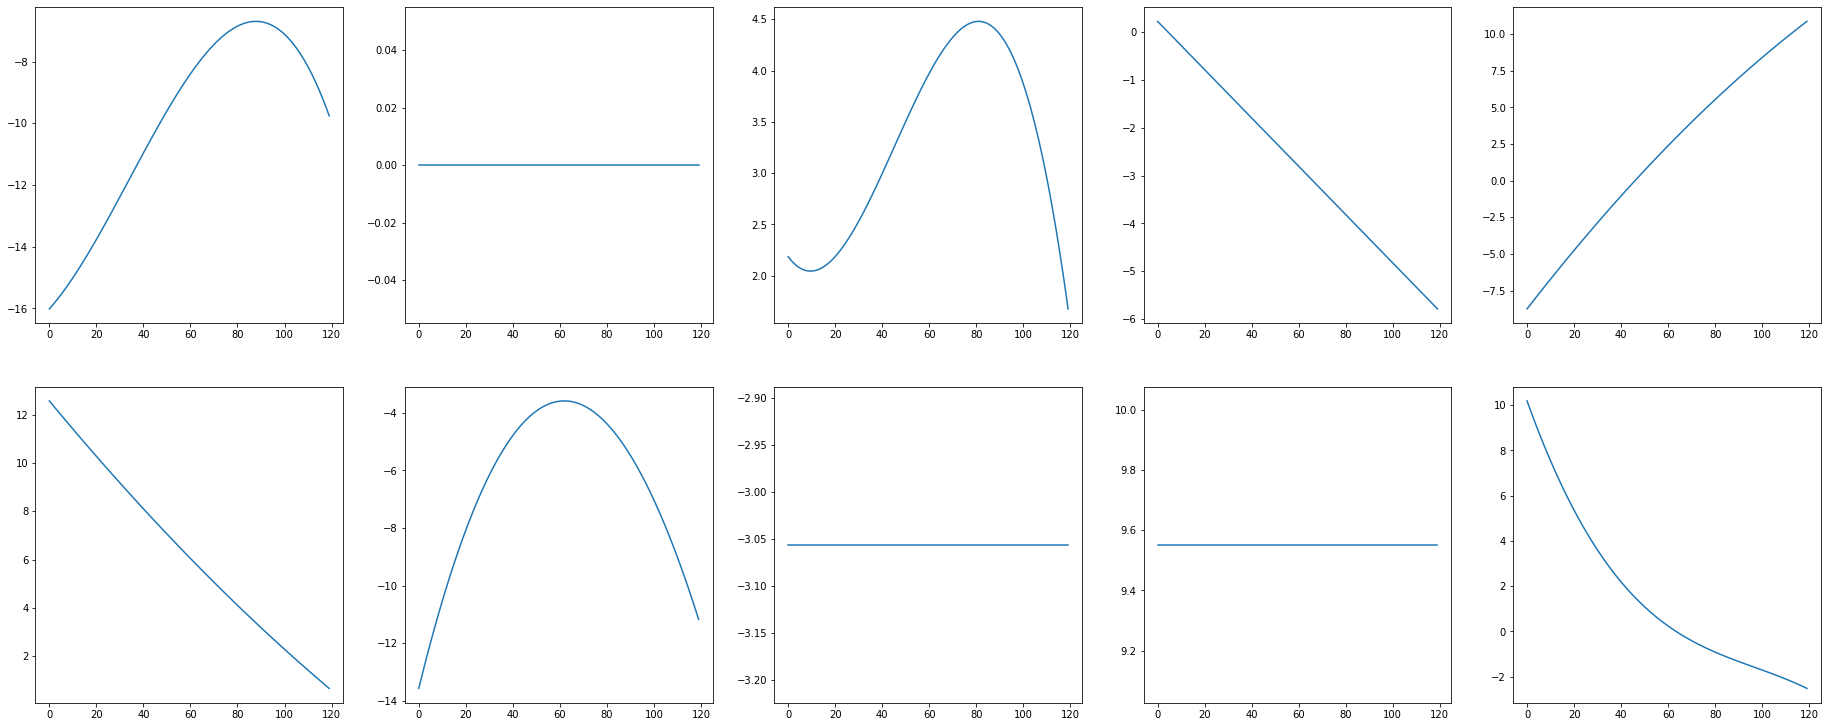

In [28]:
index=np.floor(np.random.uniform(size=[10],low=0,high=n)).astype('int32')

plt.figure(figsize=(6.4*5,6.4*2))
for i,j in zip(range(10),index):
    plt.subplot(2, 5, i+1)
    plt.plot(y[j])

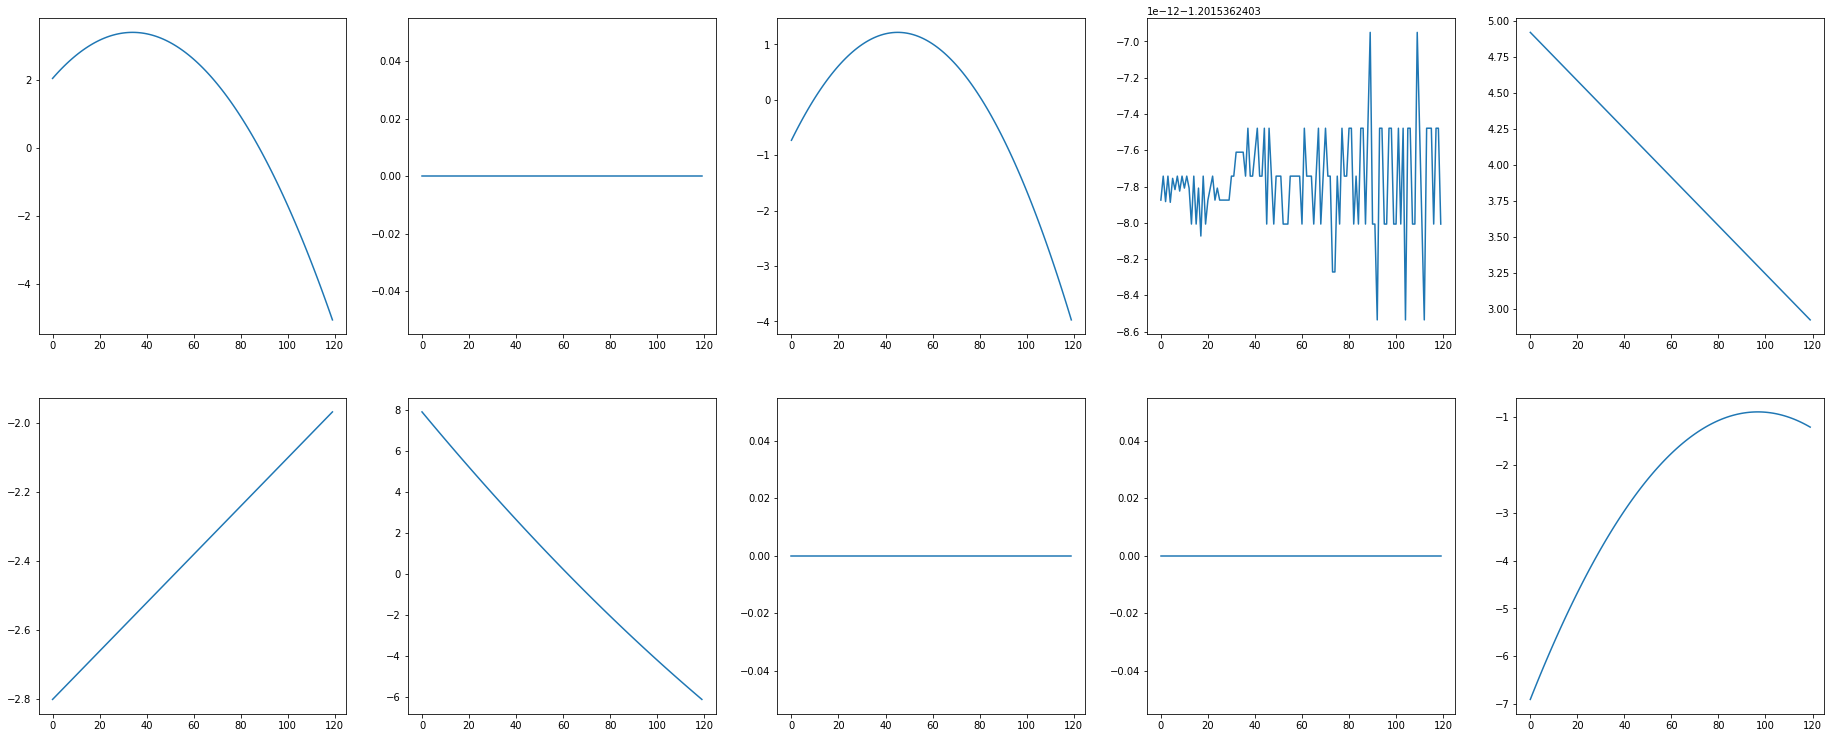

In [29]:
plt.figure(figsize=(6.4*5,6.4*2))
for i,j in zip(range(10),index):
    plt.subplot(2, 5, i+1)
    plt.plot(dy[j])

In [30]:
y = np.concatenate(np.split(y,20,axis=1),axis=0)
dy = dy[:,np.arange(2,120,6)]
dy = np.concatenate(np.split(dy,20,axis=1),axis=0)

In [31]:
indice = np.arange(y.shape[0])
np.random.shuffle(indice)
data_x = y.astype('float64')[indice]
data_y = dy.astype('float64')[indice]

In [32]:
# Conjunto de dados de treino
train_x = data_x[:-20000]
train_y = data_y[:-20000]

# Conjunto de dados de validação
test_x = data_x[-20000:]
test_y = data_y[-20000:]

In [33]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([6], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=10**-3, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando uma camada de Burgers que integra o WENO à rede neural
final_layer = Burguers_layer()

class MES_OF(tf.keras.losses.Loss):
    """Criando uma função de custo cuja superclasse é a de funções de
    custo do keras"""
    
    def call(self, y_true, y_pred):
        """
        Função que avalia o custo dado um valor de referência e um valor previsto
        --------------------------------------------------------------------------
        y_true (tensor): valor de referência
        y_pred (tensor): valor predito
        --------------------------------------------------------------------------
        loss   (tensor): custo associado
        --------------------------------------------------------------------------
        """
        y_true = tf.cast(y_true, y_pred.dtype) # Convertendo os tipos para evitar conflitos
        y_min  = tf.math.reduce_min(y_true,axis=1,keepdims=True)
        y_max  = tf.math.reduce_max(y_true,axis=1,keepdims=True)
        
        loss = tf.reduce_mean(
            tf.math.square(y_pred - y_true), axis=-1) + \
            tf.reduce_sum(
                tf.where(y_pred > y_max, y_pred - y_max,  0) + \
                tf.where(y_pred < y_min, y_min  - y_pred, 0),    
            axis=-1)
        
        return loss

# Criando a rede neural
Network = keras.Model(input_x, final_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss='MSE', optimizer=optimizer, metrics=['mean_absolute_error'])
# Carregando os pesos da rede neural treinados
#Network.load_weights('Modelo artigo')

In [34]:
# Treinando a rede neural
Network.fit(
    train_x                           , # Dados de treino
    train_y                           , # Dados de treino
    validation_data = (test_x, test_y), # Dados de validação
    batch_size      = 1024             , # Tamanho do batch
    epochs          = 100             , # Número de epochs
    steps_per_epoch = 300             , # Número de batchs por epoch
    shuffle         = True              # Aleatorização dos batchs
)

# Batch: pacote de dados utilizados antes de uma atualização dos pesos da rede
# Epoch: rodada de treino da rede neural, em geral percorre todo o conjunto de dados

Epoch 1/100
300/300 [==============================] - 5s 11ms/step - loss: 18.2003 - mean_absolute_error: 2.5202 - val_loss: 17.8798 - val_mean_absolute_error: 2.5135
Epoch 2/100
300/300 [==============================] - 3s 9ms/step - loss: 17.9198 - mean_absolute_error: 2.5080 - val_loss: 17.8797 - val_mean_absolute_error: 2.5135
Epoch 3/100
300/300 [==============================] - 3s 8ms/step - loss: 18.1138 - mean_absolute_error: 2.5130 - val_loss: 17.8797 - val_mean_absolute_error: 2.5135
Epoch 4/100
300/300 [==============================] - 3s 9ms/step - loss: 18.1249 - mean_absolute_error: 2.5208 - val_loss: 17.8797 - val_mean_absolute_error: 2.5135
Epoch 5/100
300/300 [==============================] - 3s 9ms/step - loss: 18.2396 - mean_absolute_error: 2.5208 - val_loss: 17.8797 - val_mean_absolute_error: 2.5135
Epoch 6/100
300/300 [==============================] - 3s 8ms/step - loss: 18.2087 - mean_absolute_error: 2.5226 - val_loss: 17.8797 - val_mean_absolute_error: 2.51

In [35]:
# Salvando os pesos treinados
Network.save_weights('Modelo Rede para derivada - polinomios grau 4 continuo')

In [43]:
# Carregando os pesos treinados
Network.load_weights('Modelo Rede para derivada - ABS - polinomios + senos')

In [86]:
# Calculando os erros de previsão utilizando o WENO-Z em uma malha mais fina 
# como solução de referência e depois calculando o WENO-Z e o WENO-Z com a 
# modificação da rede neural numa malha mais grossa

Δx = 1/(20*6)                                 # Distância espacial dos pontos na malha mais grossa utilizada
x  = tf.range(-2, -1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional
                             # Distância espacial dos pontos na malha utilizada

# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
f_test = lambda x: -(-tf.math.sin(np.pi*x) - 0.5 * x**3 + \
    tf.where(x < 0, tf.constant(0.0, dtype=float_pres), tf.constant(1.0, dtype=float_pres)))

full_U=f_test(x)
full_U=np.stack(np.split(full_U,20,axis=0),axis=0)

net_u   = WENO_Z_ref(full_U)             # Previsão com o WENO-Z modificado pela rede neural

In [88]:
full_U.shape

(20, 12)

In [87]:
# Calculando os erros de previsão utilizando o WENO-Z em uma malha mais fina 
# como solução de referência e depois calculando o WENO-Z e o WENO-Z com a 
# modificação da rede neural numa malha mais grossa

Δx = (1/(20*6))/2                              # Distância espacial dos pontos na malha mais grossa utilizada
x  = tf.range(-2, -1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional
                             # Distância espacial dos pontos na malha utilizada

# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
f_test = lambda x: -(-tf.math.sin(np.pi*x) - 0.5 * x**3 + \
    tf.where(x < 0, tf.constant(0.0, dtype=float_pres), tf.constant(1.0, dtype=float_pres)))

full_U=f_test(x)
full_U=np.stack(np.split(full_U,20*2,axis=0),axis=0)

debug_u   = WENO_Z_ref(full_U)[np.arange(100)*2]             # Previsão com o WENO-Z modificado pela rede neural

InvalidArgumentError: Matrix size-incompatible: In[0]: [3,20,11], In[1]: [3,5,5] [Op:BatchMatMulV2]

In [85]:
# Calculando os erros de previsão utilizando o WENO-Z em uma malha mais fina 
# como solução de referência e depois calculando o WENO-Z e o WENO-Z com a 
# modificação da rede neural numa malha mais grossa

Δx = (1/(20*6))/4                               # Distância espacial dos pontos na malha mais grossa utilizada
x  = tf.range(-2, -1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional
                             # Distância espacial dos pontos na malha utilizada

# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
f_test = lambda x: -(-tf.math.sin(np.pi*x) - 0.5 * x**3 + \
    tf.where(x < 0, tf.constant(0.0, dtype=float_pres), tf.constant(1.0, dtype=float_pres)))

full_U=f_test(x)
full_U=np.stack(np.split(full_U,20,axis=0),axis=0)

ref_full   = WENO_Z_ref(full_U)[np.arange(100)*4]             # Previsão com o WENO-Z modificado pela rede neural

# Armazenando ambos os erros de previsão
error = tf.stack([tf.squeeze(net_u)-tf.squeeze(ref_full),tf.squeeze(tf.squeeze(debug_u)-tf.squeeze(ref_full))],axis=0)

InvalidArgumentError: Matrix size-incompatible: In[0]: [3,20,23], In[1]: [3,5,5] [Op:BatchMatMulV2]

In [67]:
net_u.shape

(20000, 1)

In [65]:
# Calculando média dos erros de acordo com a norma L2, L1 ou L-inf

# Norma L2:
#--------------------------------------------------------------------------------------
desv_error = tf.math.reduce_mean(error**2, axis=1)**0.5
#--------------------------------------------------------------------------------------
print('L2:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())
print('\n')

# Norma L1:
#--------------------------------------------------------------------------------------
desv_error = tf.math.reduce_mean(tf.abs(error), axis=1)
#--------------------------------------------------------------------------------------
print('L1:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())
print('\n')

# Noma L-inf:
#-------------------------------------------------------------------------------------
desv_error = tf.math.reduce_max(tf.abs(error), axis=1)
#--------------------------------------------------------------------------------------
print('L-inf:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())

L2:
[4958.91748903 4908.82741338]
1.0102040816326534


L1:
[1071.91127608 1061.08388945]
1.0102040816326532


L-inf:
[91980.86572721 91051.7660734 ]
1.0102040816326532


In [22]:
@tf.function # Ornamento que transforma a função em uma função do tensorflow
def Burgers(u, t_final, Δx, CFL, fronteira, network=Null_net.Network):
    """
    Função que recebe um tensor u contendo os valores de uma determinada função e retorna os 
    valores após Δt unidades de tempo estimados de acordo com a equação de Burgers
    -------------------------------------------------------------------------------------------
    u           (tensor): valores da condição inicial da função
    t_final      (float): unidades de tempo a serem avançadas
    Δx           (float): distância espacial dos pontos na malha utilizada
    CFL          (float): constante utilizada para determinar o tamanho da malha temporal
    fronteira (function): função que determina o comportamento do algoritmo na fronteira
    network   (function): função que computa o valor de saída da rede neural a partir do valor 
                          de entrada
    -------------------------------------------------------------------------------------------
    u           (tensor): valores da função após Δt unidades de tempo
    -------------------------------------------------------------------------------------------
    """
    
    t = tf.math.reduce_max(tf.abs(u), axis=1, keepdims=True)*0 # Instante de tempo incial para a computação

    while tf.math.reduce_any(t < t_final):
        Λ  = tf.math.reduce_max(tf.abs(u), axis=1, keepdims=True)

        # Obtendo o valor de Δt a partir de CFL
        Δt = Δx*CFL/Λ  
        u=Burgers_step(u,Δx,CFL,t,t_final, fronteira, network)
        t  = t + Δt # Avançando no tempo
    return u

def Burgers_step(u,Δx,CFL,t,t_final, fronteira, network):
    Λ  = tf.math.reduce_max(tf.abs(u), axis=1, keepdims=True)
    Δt = Δx*CFL/Λ  
    # Caso o passo temporal utrapasse o valor de t_final então o 
    # tamanho do passo se torna o tempo que falta para se obter o 
    # t_final
    Δt = tf.where(t + Δt > t_final, t_final - t, Δt)

    # SSP Runge-Kutta 3,3
    u1 = u - Δt*DerivadaEspacial(u, Δx, fronteira, network)
    u2 = (3*u + u1 - Δt*DerivadaEspacial(u1, Δx, fronteira, network)) / 4.0
    u  = (u + 2*u2 - 2*Δt*DerivadaEspacial(u2, Δx, fronteira, network)) / 3.0
    return u

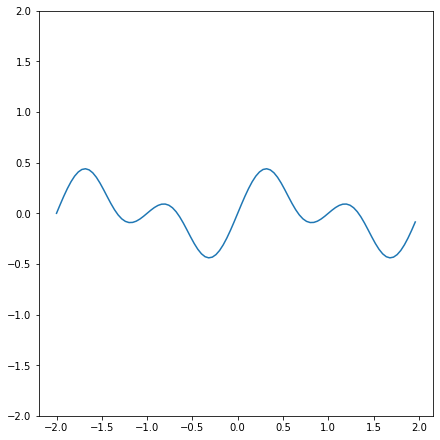

KeyboardInterrupt: 

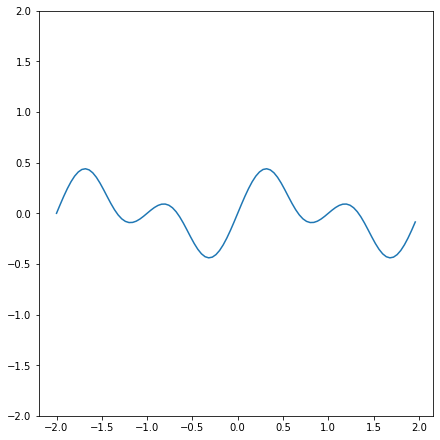

In [23]:
# Visualizando o ajuste do WENO-Z com a modificação da rede neural

Δx = 0.04                                  # Distância espacial dos pontos na malha utilizada
x  = tf.range(-2, 2, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional

# Gerando uma condição inicial aleatória
#------------------------------------------------------------------------------------------------------------------
# k1 = tf.random.uniform([1], 0, 20, dtype='int32')   # Amostrando uma frequência aleatória para a função seno
# k1 = tf.cast(k1, dtype=float_pres)                  # Mudando o tipo do tensor
# k2 = tf.random.uniform([1], 0, 20, dtype='int32')   # Amostrando uma frequência aleatória para a função seno
# k2 = tf.cast(k2, dtype=float_pres)                  # Mudando o tipo do tensor
# a  = tf.random.uniform([1], 0, 1, dtype=float_pres) # Amostrando um peso aleatória para ponderar as funções seno
# b  = tf.random.uniform([1], 0, 2, dtype=float_pres) # Amostrando um modificador de amplitude aleatório
#------------------------------------------------------------------------------------------------------------------

# Fixando a condição inicial
#-----------------------------------------------
k1 = 1.0 # Frequência para a função seno
k2 = 2.0 # Frequência para a função seno
a  = 0.5 # Peso para ponderar as funções seno
b  = 0.5 # Modificador de amplitude
#-----------------------------------------------


u1 =     a * tf.expand_dims(tf.math.sin(k1*pi*x),axis=1) # Gerando pontos de acordo com a primeira função seno
u2 = (1-a) * tf.expand_dims(tf.math.sin(k2*pi*x),axis=1) # Gerando pontos de acordo com a segunda função seno

u = b*(u1+u2)                 # Obtendo a condição inicial a partir das funções senos
u = tf.expand_dims(u, axis=0) # Acrescentando uma dimensão

CFL = 0.5                          # Constante utilizada para determinar o tamanho da malha temporal
Δt  = 0.01                         # Δt entre cada frame de animação
T   = tf.range(0.0, 2.0, Δt)       # Frames da animação
T   = tf.cast(T, dtype=float_pres) # Mudando o tipo do tensor

t = 0.0 # Instante de tempo inicial


# Gerando os gráficos a partir de funções do matplotlib

fig = plt.figure(1, constrained_layout=True,figsize=(6,6))
ax = fig.add_subplot(1,1,1);
ax.set_ylim(-2, 2);
#ax.set_xlim(0,1);
line=ax.plot(x,tf.squeeze(u))
hfig = display(fig, display_id=True)
Δt_list=tf.zeros([0],dtype=float_pres)


while t < T[-1]:
    
    # Executando o WENO-Z modificado pela rede neural
    u = Burgers(u, tf.constant(Δt,dtype='float64'), tf.constant(Δx,dtype='float64'), tf.constant(CFL,dtype='float64'), FronteiraPeriodica, network=final_layer.network_graph) 
    
    # Removendo dimensões desnecessárias
    squeezed_u=tf.squeeze(u)
    
    # Avançando no tempo
    t += Δt

    # Exibindo graficamente os valores obtidos
    line[0].set_ydata(squeezed_u.numpy())
    fig.canvas.draw()
    hfig.update(fig)